# TreeRBM usage example

Import dependences

In [1]:
import sys
import os
home = '/'.join(os.getcwd().split('/')[:-1])

In [8]:
os.chdir(home)
sys.path.append(home + '/src')
sys.path.append(home + '/data')
import importlib
import treeRBM
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot
import json
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

from tools.tools_binary import iterate_mean_field, profile_hiddens, profile_visibles

## Load the model

In [3]:
fname_data = 'data/HGD/HGD.dat'
fname_model = 'models/2023.11.23.22.28-dna-1000.h5'

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Visualize data and TAP fixed points

In [20]:
data = torch.tensor(np.loadtxt(fname_data), device=device, dtype=torch.float32)
_, _, Vt = torch.linalg.svd(data - data.mean(0))
data_proj = data @ Vt.mT

In [21]:
f_model = h5py.File(fname_model, "r+")
checkpoints = treeRBM.get_epochs(fname_model)
params = treeRBM.get_params(filename=fname_model, stamp=checkpoints[-1], device=device)

In [22]:
mh = profile_hiddens(v=data, hbias=params[1], weight_matrix=params[2])
mv = profile_visibles(h=mh, vbias=params[0], weight_matrix=params[2])

fp = iterate_mean_field(
    X=(mv, mh),
    params=params,
    order=2,
    batch_size=10000,
    device=device
)[0]


Iterating Mean Field: 100%|##########| 1/1 [00:00<00:00,  2.83it/s]


In [23]:
fp_proj = fp @ Vt.mT

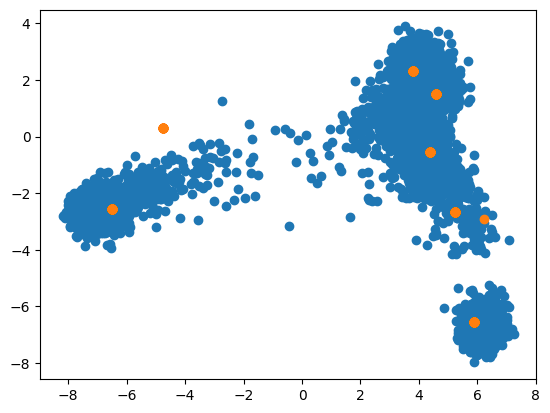

In [24]:
plt.scatter(data_proj[:, 0].cpu().numpy(), data_proj[:, 1].cpu().numpy())
plt.scatter(fp_proj[:, 0].cpu().numpy(), fp_proj[:, 1].cpu().numpy())